In [277]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
dir='/Users/ch/K2/projects/chiron/database/'

import pandas as pd
df=pd.read_csv('/Users/ch/Downloads/radec.csv')
c=SkyCoord(df.ra,df.dec,unit=(u.hourangle,u.deg))



def load_cadence(campaign=None,channel=None,cadence=None,dir=dir):
    if (channel is None):
        fname=(dir+'c{}/{}/0.h5'.format('{0:02}'.format(campaign),'*'))
    else:
        fname=(dir+'c{}/{}/0.h5'.format('{0:02}'.format(campaign),'{0:02}'.format(channel)))
    df=dd.read_hdf(fname, key='table')
    if (cadence is None)== False:
        xmin,xmax,ymin,ymax=(df['X'].min().compute()),(df['X'].max().compute()),(df['Y'].min().compute()),(df['Y'].max().compute())
        ar=np.zeros((int(xmax-xmin)+1,int(ymax-ymin)+1))
        ar[:]=np.nan
        x,y,f=np.asarray(df[['X','Y',df.columns[4+cadence]]].compute()).T
        ar[x.astype(int)-int(xmin),y.astype(int)-int(ymin)]=f
        return ar
    else:
        a=np.asarray(df)
        ra,dec,x,y=a[:,0:4].T
        a=a[:,4:]
        results={'ra':ra,'dec':dec,'x':x,'y':y,'a':a}
        return results


    
def find_loc(loc):
    #Find the location, should be it's own function. Should output the right channel number.
    if (loc is None):
        print ('No location specified')
        return None
    if (isinstance(loc,tuple) == False):
        print ('Please pass a tuple location')
        return None
    xpos,ypos=loc[0],loc[1]
    radec=False
    if (isinstance(xpos,u.quantity.Quantity)):
        #Specified RA and Dec
        radec=True
        xpos,ypos=xpos.value,ypos.value
    if radec == True:
        wcs_file='/Users/ch/K2/repos/k2mosaic/k2mosaic/data/wcs/c{0:02}_'.format(campaign)+'{0:02}.p'.format(channel)
        r = pickle.load(open(wcs_file,'rb'))
        y1,x1=(np.asarray(r.wcs_world2pix(xpos,ypos,1),dtype=int))
        
    else:
        y1,x1=ypos,xpos
        
    if y1<=0. or y1>=1034:
        print ('Out of bounds')
    if x1<=0. or x1>=1034:
        print ('Out of bounds')
    return x1,y1,radec
    
    
    

    
    
def load_loc(campaign=None,channel=None,cadence=None,loc=(512,512),dir=dir,tol=50,return_radec=False,return_xy=False):
    '''Loads a location on the focal plane based on either input RAs and Decs or input X and Y positions
    Specify either a single cadence, an array of cadences or None for all.
    Specify a channel at the moment, should remove.'''

    x1,y1,radec=find_loc(loc)


    #Load the channels into a dask array
    if (channel is None):
        fname=(dir+'c{}/{}/0.h5'.format('{0:02}'.format(campaign),'*'))
    else:
        fname=(dir+'c{}/{}/0.h5'.format('{0:02}'.format(campaign),'{0:02}'.format(channel)))
    df=dd.read_hdf(fname, key='table')

    
    #If a cadence is specified...
    if (cadence is None) == False:
        #Trim down to only the important data.
        df1=df[(df['X']>x1-tol)&(df['X']<x1+tol)&(df['Y']>y1-tol)&(df['Y']<y1+tol)]


        ar=np.zeros((tol*2,tol*2))*np.nan
        x,y,f=np.asarray(df1[['X','Y',df1.columns[4+cadence]]].compute()).T
        ar[x.astype(int)-x1+tol,y.astype(int)-y1+tol]=f        
        if (return_radec == True) or (return_xy == True):
            x=np.arange(-tol,tol)+x1
            y=np.arange(-tol,tol)+y1
            X,Y=np.meshgrid(y,x)
            if return_xy == True:
                return ar,X,Y
            wcs_file='/Users/ch/K2/repos/k2mosaic/k2mosaic/data/wcs/c{0:02}_'.format(campaign)+'{0:02}.p'.format(channel)
            r = pickle.load(open(wcs_file,'rb'))
            ra,dec=r.wcs_pix2world(X.ravel(),Y.ravel(),1)
            ra,dec=np.reshape(ra,np.shape(X)),np.reshape(dec,np.shape(X))
            return ar,ra,dec
        else:
            return ar
        
        
    #If no cadence is specified...    
    else:
        #Trim down to only the important data.
        df1=df[(df['X']>x1-tol)&(df['X']<x1+tol)&(df['Y']>y1-tol)&(df['Y']<y1+tol)]
        a=np.asarray(df1.compute())
        x,y=a[:,2:4].T
        a=a[:,4:].T
        ar=np.reshape(np.zeros(tol*2*tol*2*len(a)),(tol*2,tol*2,len(a)))
        ar[x.astype(int)-x1+tol,y.astype(int)-y1+tol,:]=a.T        
        if (return_radec == True) or (return_xy == True):
            x=np.arange(-tol,tol)+x1
            y=np.arange(-tol,tol)+y1
            X,Y=np.meshgrid(y,x)
            if return_xy == True:
                return ar,X,Y
            wcs_file='/Users/ch/K2/repos/k2mosaic/k2mosaic/data/wcs/c{0:02}_'.format(campaign)+'{0:02}.p'.format(channel)
            r = pickle.load(open(wcs_file,'rb'))
            ra,dec=r.wcs_pix2world(X.ravel(),Y.ravel(),1)
            ra,dec=np.reshape(ra,np.shape(X)),np.reshape(dec,np.shape(X))
            return ar,ra,dec
        else:
            return ar




[autoreload of k2movie failed: Traceback (most recent call last):
  File "/Users/ch/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/Users/ch/anaconda/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/Users/ch/anaconda/lib/python3.6/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/ch/anaconda/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 205, in _call_with_frames_removed
  File "../source/k2movie.py", line 92
    print np

CPU times: user 1.35 s, sys: 451 ms, total: 1.8 s
Wall time: 1.8 s


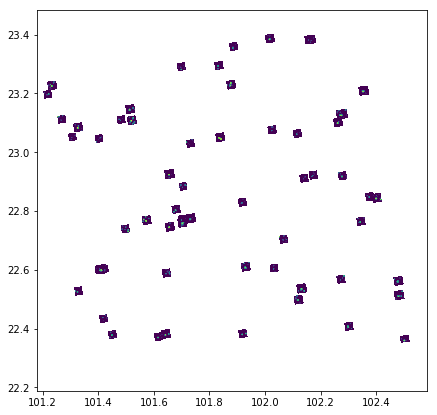

In [172]:
%time ar,ra,dec=load_loc(campaign=0,channel=23,cadence=1999,tol=512,return_radec=True)
plt.figure(figsize=(7,7))
plt.contourf(ra,dec,np.log10(ar),vmin=3,vmax=5)


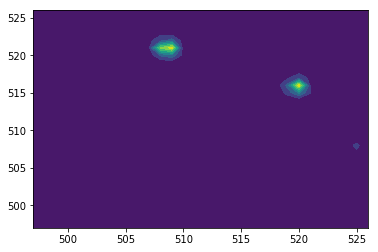

In [98]:
plt.contourf(ar[1],ar[2],ar[0][:,:,2000])

(18.4, 18.7)

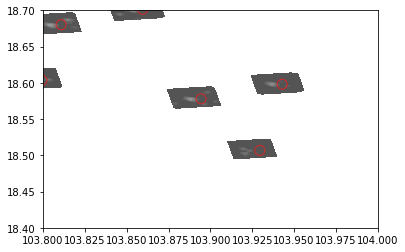

In [278]:
from astropy.io import fits
cmap=plt.get_cmap('Greys_r')
cmap.set_bad('white',1.)
h=fits.open('/Users/ch/K2/projects/chiron/data/c0-ch01/k2mosaic-c00-ch01-cad87434.fits')
wcs_file='/Users/ch/K2/repos/k2mosaic/k2mosaic/data/wcs/c{0:02}_'.format(0)+'{0:02}.p'.format(1)
r = pickle.load(open(wcs_file,'rb'))
s=np.shape(h[1].data)
x,y=np.meshgrid(np.arange(s[1]),np.arange(s[0]))
ra,dec=r.wcs_pix2world(x.ravel(),y.ravel(),1)
ra,dec=np.reshape(ra,s),np.reshape(dec,s)
plt.contourf(ra,dec,np.log10(h[1].data),cmap=cmap,vmin=0,vmax=10)
plt.scatter(c.ra.deg,c.dec.deg,edgecolor='C3',marker='o',s=100,facecolor='none')
plt.xlim(103.8,104)
plt.ylim(18.4,18.7)

In [209]:
import sys
sys.path.append('../source/')
import k2movie
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
mov=k2movie.k2movie(cadence=0,loc=(104.45*u.deg,18.95*u.deg),verbose=True,return_radec=True,tol=15).compute()

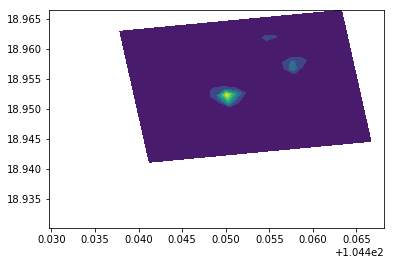

In [272]:
plt.contourf(mov[1],mov[2],mov[0][:,:,1])

In [287]:
print (np.shape(mov[0]))

(30, 30, 3753)


In [295]:
df.loc[[0]]

,ra,dec,kpmag
0,06 57 39.600,+19 35 03.98,9.5
